In [1]:
# Caltech Small Dataset - Google Colab

import zipfile

!rm -f /content/download
!rm -rf /content/caltech-transportation_train
!rm -rf /content/caltech-transportation_test
!wget https://vc.ee.duth.gr:6960/index.php/s/4PIELUtjzbSmfYf/download -O /content/download
local_zip = '/content/download'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

TRAIN_DIR = '/content/caltech-transportation_train'
TEST_DIR = '/content/caltech-transportation_test'
NUM_CLASSES = 5
DATASET_NAME = "Caltech-Transportation"

print(f"Dataset: {DATASET_NAME}")
print(f"Train: {TRAIN_DIR}")
print(f"Test: {TEST_DIR}")
print(f"Classes: {NUM_CLASSES}")

--2025-12-15 16:45:03--  https://vc.ee.duth.gr:6960/index.php/s/4PIELUtjzbSmfYf/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17022955 (16M) [application/zip]
Saving to: ‘/content/download’

/content/download   100%[===================>]  16.23M   958KB/s    in 18s     

2025-12-15 16:45:22 (923 KB/s) - ‘/content/download’ saved [17022955/17022955]

Dataset: Caltech-Transportation
Train: /content/caltech-transportation_train
Test: /content/caltech-transportation_test
Classes: 5


In [ ]:
# Β' ΜΕΡΟΣ - Deep Learning με Keras/TensorFlow

## Εργασία 3: Ταξινόμηση Πολλαπλών Κλάσεων με CNNs

# Αυτό το notebook υλοποιεί:
# 1. **Custom CNN** - Δίκτυο δημιουργημένο από την αρχή
# 2. **Transfer Learning** - Προ-εκπαιδευμένο δίκτυο (VGG16)

# Τα δίκτυα θα εκπαιδευτούν και θα αξιολογηθούν σε **2 datasets**:
# - **Dataset 1**: Caltech-Transportation (5 κλάσεις)
# - **Dataset 2**: GTSRB German Traffic Signs (43 κλάσεις)


test_modified  train_modified


## 1. Εγκατάσταση και Import Βιβλιοθηκών

In [3]:
# Εγκατάσταση απαραίτητων βιβλιοθηκών (για Google Colab)
# !pip install tensorflow keras matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.10.0


## 2. Διαμόρφωση (Configuration)

### Επιλογή Dataset
- `DATASET = 1` για **Caltech-Transportation** (5 κλάσεις)
- `DATASET = 2` για **GTSRB** (43 κλάσεις)

In [4]:
# =====================================================
# HYPERPARAMETERS - Ρυθμίσεις εκπαίδευσης
# =====================================================
# ΣΗΜΑΝΤΙΚΟ: Τα paths (TRAIN_DIR, TEST_DIR, NUM_CLASSES, DATASET_NAME) 
# ορίζονται στο πρώτο cell όπου γίνεται και το download του dataset!

# Hyperparameters
IMG_SIZE = (128, 128)  # Μέγεθος εικόνων εισόδου
BATCH_SIZE = 32
EPOCHS = 30

print(f"Dataset: {DATASET_NAME}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Dataset: Caltech-Transportation
Train directory: /content/caltech-transportation_train
Test directory: /content/caltech-transportation_test
Number of classes: 5
Image size: (128, 128)
Batch size: 32
Epochs: 30


## 3. Φόρτωση και Προεπεξεργασία Δεδομένων

### Data Augmentation
Χρησιμοποιούμε `ImageDataGenerator` για:
- **Rotation** (περιστροφή έως 20°)
- **Width/Height shift** (μετατόπιση)
- **Horizontal flip** (οριζόντια αναστροφή)
- **Zoom** (μεγέθυνση/σμίκρυνση)
- **Rescaling** (κανονικοποίηση [0,1])

In [5]:
# Data Augmentation για training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Κανονικοποίηση [0,1]
    rotation_range=20,        # Περιστροφή έως 20°
    width_shift_range=0.2,    # Οριζόντια μετατόπιση
    height_shift_range=0.2,   # Κάθετη μετατόπιση
    horizontal_flip=True,     # Οριζόντια αναστροφή
    zoom_range=0.2,           # Μεγέθυνση/σμίκρυνση
    fill_mode='nearest',
    validation_split=0.2      # 20% για validation
)

# Μόνο rescaling για test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Φόρτωση δεδομένων με flow_from_directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Εμφάνιση πληροφοριών
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Classes: {list(train_generator.class_indices.keys())}")

Found 1165 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Found 366 images belonging to 5 classes.

Training samples: 1165
Validation samples: 288
Test samples: 366
Classes: ['Motorbikes', 'airplanes', 'car_side', 'ferry', 'inline_skate']


## 4. Οπτικοποίηση Δειγμάτων Εκπαίδευσης

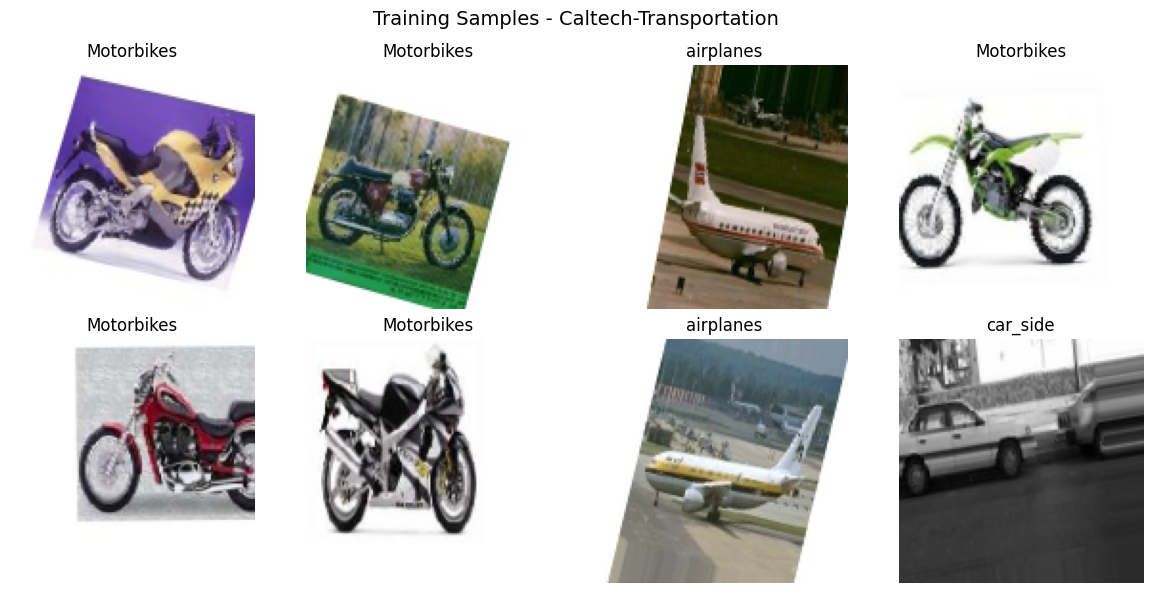

In [6]:
# Εμφάνιση δείγματος εικόνων
def show_sample_images(generator, title="Sample Images"):
    batch = next(generator)
    images, labels = batch
    
    class_names = list(generator.class_indices.keys())
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=14)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            label_idx = np.argmax(labels[i])
            ax.set_title(class_names[label_idx])
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Reset generator
train_generator.reset()
show_sample_images(train_generator, f"Training Samples - {DATASET_NAME}")

## 5. Custom CNN - Μη Προ-εκπαιδευμένο Δίκτυο

### Αρχιτεκτονική
Το δίκτυο αποτελείται από:
- **3 Convolutional Blocks**: Conv2D → BatchNorm → MaxPooling → Dropout
- **Fully Connected Layers**: Flatten → Dense(256) → Dropout → Dense(NUM_CLASSES)
- **Activation**: ReLU για τα κρυφά, Softmax για την έξοδο

In [9]:
def build_custom_cnn(input_shape, num_classes):
    """
    Δημιουργία Custom CNN από την αρχή.
    
    Αρχιτεκτονική:
    - 3 Convolutional Blocks με αυξανόμενο αριθμό φίλτρων (32, 64, 128)
    - BatchNormalization για σταθεροποίηση
    - MaxPooling για μείωση διαστάσεων
    - Dropout για regularization
    - Dense layers για ταξινόμηση
    """
    model = models.Sequential([
        # Block 1: 32 filters
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                      input_shape=input_shape, name='conv1_1'),
        layers.BatchNormalization(name='bn1'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25, name='dropout1'),
        
        # Block 2: 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
        layers.BatchNormalization(name='bn2'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25, name='dropout2'),
        
        # Block 3: 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),
        layers.BatchNormalization(name='bn3'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.25, name='dropout3'),
        
        # Fully Connected Layers
        layers.Flatten(name='flatten'),
        layers.Dense(256, activation='relu', name='fc1'),
        layers.BatchNormalization(name='bn_fc'),
        layers.Dropout(0.5, name='dropout_fc'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Δημιουργία του μοντέλου
input_shape = (*IMG_SIZE, 3)  # (128, 128, 3)
custom_cnn = build_custom_cnn(input_shape, NUM_CLASSES)

# Compile
custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Εμφάνιση αρχιτεκτονικής
print("=" * 60)
print("CUSTOM CNN ARCHITECTURE")
print("=" * 60)
custom_cnn.summary()

# Συνολικός αριθμός παραμέτρων
total_params = custom_cnn.count_params()
print(f"\nTotal Parameters: {total_params:,}")

CUSTOM CNN ARCHITECTURE


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_fc (BatchNormalization)      │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,679,077 (33.11 MB)

 Trainable params: 8,678,117 (33.10 MB)

 Non-trainable params: 960 (3.75 KB)


Total Parameters: 8,679,077


### 5.1 Εκπαίδευση Custom CNN

**Device που μπορούν να χρησιμοποιηθούν:**
- `TPU`: Η google έχει πολύ αξιόλογο hardware που μπορεί να εκπαιδεύσει νευρωνικά δίκτυα, πολύ πιο βολικό για άτομα που ασχολούνται με έρευνα
- `GPU`: Η συνήθης επιλογή. Χρησιμοποιήσα μια  [T4 GPU](https://cloud.google.com/compute/gpus-pricing?hl=en) για την εκπαίδευση
- `CPU`: Επίσης Επιλογή 

**Callbacks που χρησιμοποιούνται:**
- `EarlyStopping`: Σταματά αν δεν βελτιώνεται το validation loss για 5 epochs
- `ReduceLROnPlateau`: Μειώνει το learning rate αν σταματήσει η βελτίωση
- `ModelCheckpoint`: Αποθηκεύει το καλύτερο μοντέλο

In [10]:
tf.debugging.set_log_device_placement(True)
# with tf.device('/device:cpu:1'): # Αν θέλετε αλλάξτε σε αυτό
with tf.device('/device:gpu:1'):
    # Callbacks
    custom_callbacks = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=f'custom_cnn_{DATASET_NAME.lower().replace("-", "_")}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Reset generators
    train_generator.reset()
    validation_generator.reset()

    # Εκπαίδευση
    print("=" * 60)
    print("TRAINING CUSTOM CNN")
    print("=" * 60)

    custom_history = custom_cnn.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=custom_callbacks,
        verbose=1
    )

TRAINING CUSTOM CNN
Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6962 - loss: 1.0886
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to custom_cnn_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 522ms/step - accuracy: 0.6988 - loss: 1.0785 - val_accuracy: 0.4444 - val_loss: 3.8521 - learning_rate: 0.0010
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8721 - loss: 0.4791
Epoch 2: val_accuracy did not improve from 0.44444
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.8726 - loss: 0.4766 - val_accuracy: 0.4444 - val_loss: 6.1521 - learning_rate: 0.0010
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9129 - loss: 0.2968
Epoch 3: val_accuracy did not improve from 0.44444
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.9128 - loss: 0.2973 - val_accuracy: 0.4444 - val_loss: 6.3919 - learning_rate: 0.0010
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9161 - loss: 0.2767
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.44444
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.9161 - loss: 0.2768 - val_accurac

### 5.2 Γραφήματα Εκπαίδευσης Custom CNN

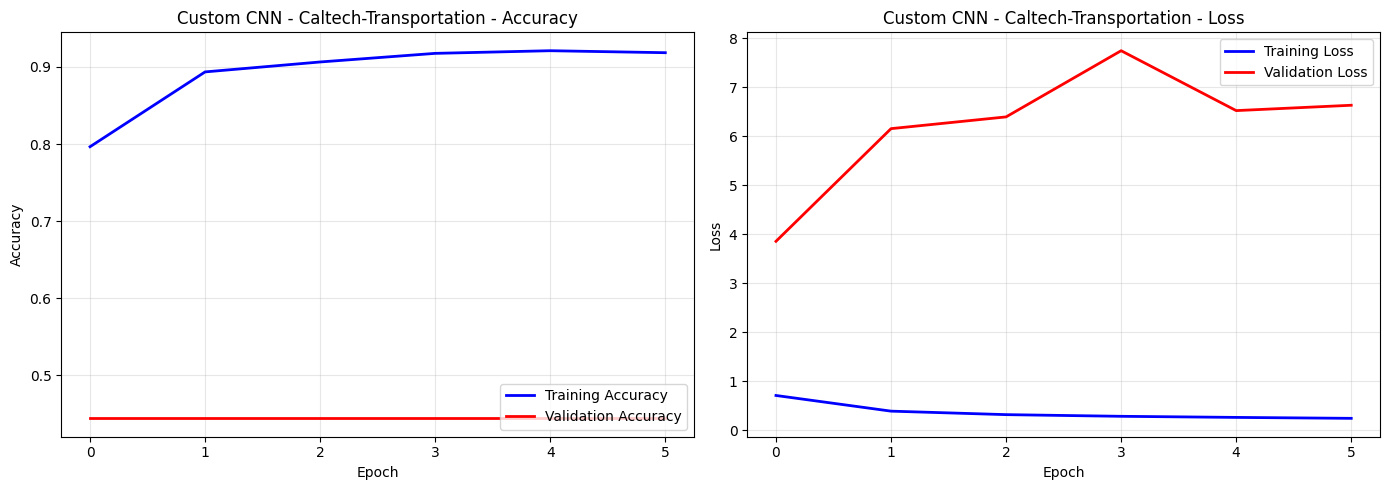

In [11]:
def plot_training_history(history, title="Training History"):
    """Γραφήματα accuracy και loss κατά την εκπαίδευση"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{title} - Accuracy', fontsize=12)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_title(f'{title} - Loss', fontsize=12)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot Custom CNN training history
plot_training_history(custom_history, f"Custom CNN - {DATASET_NAME}")

### 5.3 Αξιολόγηση Custom CNN στο Test Set

In [12]:
# Αξιολόγηση στο test set
test_generator.reset()
custom_cnn_results = custom_cnn.evaluate(test_generator, verbose=1)

print("\n" + "=" * 60)
print(f"CUSTOM CNN - TEST RESULTS ({DATASET_NAME})")
print("=" * 60)
print(f"Test Loss: {custom_cnn_results[0]:.4f}")
print(f"Test Accuracy: {custom_cnn_results[1]*100:.2f}%")
print("=" * 60)

# Αποθήκευση αποτελεσμάτων για σύγκριση
custom_cnn_accuracy = custom_cnn_results[1]

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.2385 - loss: 5.7023

CUSTOM CNN - TEST RESULTS (Caltech-Transportation)
Test Loss: 3.7647
Test Accuracy: 43.72%


## 6. Transfer Learning - VGG16 Προ-εκπαιδευμένο Δίκτυο

### Ανάλυση VGG16
Το **VGG16** είναι ένα βαθύ συνελικτικό δίκτυο που αναπτύχθηκε από τo Visual Geometry Group του Oxford:

- **Βάθος**: 16 επίπεδα με βάρη (13 Conv + 3 FC)
- **Φίλτρα**: Μόνο 3x3 convolutions
- **Pooling**: 2x2 max pooling
- **Προ-εκπαίδευση**: ImageNet (1000 κλάσεις)
- **Παράμετροι**: ~138 εκατομμύρια

### Στρατηγική Fine-tuning
1. Φορτώνουμε VGG16 χωρίς τα τελικά Dense layers
2. "Παγώνουμε" τα convolutional layers
3. Προσθέτουμε δικά μας Dense layers για τις κλάσεις μας
4. Εκπαιδεύουμε μόνο τα νέα layers

In [13]:
def build_transfer_learning_model(input_shape, num_classes):
    """
    Transfer Learning με VGG16.
    
    Στρατηγική:
    - Χρήση VGG16 ως feature extractor
    - Πάγωμα convolutional layers
    - Custom classifier στην κορυφή
    """
    # Φόρτωση VGG16 χωρίς τα Dense layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Πάγωμα base model
    base_model.trainable = False
    
    # Δημιουργία του πλήρους μοντέλου
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name='gap'),
        layers.Dense(512, activation='relu', name='fc1'),
        layers.BatchNormalization(name='bn1'),
        layers.Dropout(0.5, name='dropout1'),
        layers.Dense(256, activation='relu', name='fc2'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model, base_model

# Δημιουργία Transfer Learning model
transfer_model, vgg_base = build_transfer_learning_model(input_shape, NUM_CLASSES)

# Compile
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Εμφάνιση αρχιτεκτονικής
print("=" * 60)
print("TRANSFER LEARNING (VGG16) ARCHITECTURE")
print("=" * 60)
transfer_model.summary()

# Πληροφορίες για trainable parameters
trainable_params = sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in transfer_model.non_trainable_weights])
print(f"\nTrainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters (frozen VGG16): {non_trainable_params:,}")
print(f"Total Parameters: {trainable_params + non_trainable_params:,}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
TRANSFER LEARNING (VGG16) ARCHITECTURE


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,005 (57.65 MB)

 Trainable params: 396,293 (1.51 MB)

 Non-trainable params: 14,715,712 (56.14 MB)


Trainable Parameters: 396,293
Non-trainable Parameters (frozen VGG16): 14,715,712
Total Parameters: 15,112,005


### 6.1 Εκπαίδευση Transfer Learning Model

In [15]:
# Callbacks για Transfer Learning
transfer_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=f'transfer_vgg16_{DATASET_NAME.lower().replace("-", "_")}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Reset generators
train_generator.reset()
validation_generator.reset()

# Εκπαίδευση
print("=" * 60)
print("TRAINING TRANSFER LEARNING MODEL (VGG16)")
print("=" * 60)

transfer_history = transfer_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=transfer_callbacks,
    verbose=1
)

TRAINING TRANSFER LEARNING MODEL (VGG16)
Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7032 - loss: 0.8360
Epoch 1: val_accuracy improved from -inf to 0.82986, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 382ms/step - accuracy: 0.7069 - loss: 0.8260 - val_accuracy: 0.8299 - val_loss: 0.5717 - learning_rate: 0.0010
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9690 - loss: 0.1230
Epoch 2: val_accuracy improved from 0.82986 to 0.87500, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.9689 - loss: 0.1228 - val_accuracy: 0.8750 - val_loss: 0.4085 - learning_rate: 0.0010
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9723 - loss: 0.0945
Epoch 3: val_accuracy improved from 0.87500 to 0.89236, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9722 - loss: 0.0945 - val_accuracy: 0.8924 - val_loss: 0.3184 - learning_rate: 0.0010
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9707 - loss: 0.0885
Epoch 4: val_accuracy improved from 0.89236 to 0.91319, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.9707 - loss: 0.0883 - val_accuracy: 0.9132 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9729 - loss: 0.1133
Epoch 5: val_accuracy improved from 0.91319 to 0.94444, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.9729 - loss: 0.1130 - val_accuracy: 0.9444 - val_loss: 0.2001 - learning_rate: 0.0010
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9777 - loss: 0.0640
Epoch 6: val_accuracy did not improve from 0.94444
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9776 - loss: 0.0644 - val_accuracy: 0.9201 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9812 - loss: 0.0699
Epoch 7: val_accuracy did not improve from 0.94444
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.9811 - loss: 0.0698 - val_accuracy: 0.9340 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9798 - loss: 0.0584
Epoch 8: val_accuracy improved from 0.94444 to 0.95486, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9797 - loss: 0.0588 - val_accuracy: 0.9549 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9702 - loss: 0.0769
Epoch 9: val_accuracy did not improve from 0.95486
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.9703 - loss: 0.0766 - val_accuracy: 0.9514 - val_loss: 0.1360 - learning_rate: 0.0010
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9813 - loss: 0.0682
Epoch 10: val_accuracy improved from 0.95486 to 0.95833, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.9813 - loss: 0.0682 - val_accuracy: 0.9583 - val_loss: 0.1358 - learning_rate: 0.0010
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9769 - loss: 0.0705
Epoch 11: val_accuracy did not improve from 0.95833
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.9769 - loss: 0.0705 - val_accuracy: 0.9583 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9778 - loss: 0.0459
Epoch 12: val_accuracy did not improve from 0.95833
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.9777 - loss: 0.0461 - val_accuracy: 0.9549 - val_loss: 0.1178 - learning_rate: 0.0010
Epoch 13/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9894 - loss: 0.0341
Epoch 13: val_accuracy improved from 0.95833 to 0.96875, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9894 - loss: 0.0340 - val_accuracy: 0.9688 - val_loss: 0.1137 - learning_rate: 0.0010
Epoch 14/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9867 - loss: 0.0319
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_accuracy did not improve from 0.96875
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9866 - loss: 0.0321 - val_accuracy: 0.9688 - val_loss: 0.1177 - learning_rate: 0.0010
Epoch 15/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9821 - loss: 0.0726
Epoch 15: val_accuracy improved from 0.96875 to 0.97569, saving model to transfer_vgg16_caltech_transportation.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9821 - loss: 0.0721 - val_accuracy: 0.9757 - val_loss: 0.0904 - learning_rate: 5.0000e-04
Epoch 16/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9915 - loss: 0.0217
Epoch 16: val_accuracy did not improve from 0.97569
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.9915 - loss: 0.0217 - val_accuracy: 0.9757 - val_loss: 0.0971 - learning_rate: 5.0000e-04
Epoch 17/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9892 - loss: 0.0302
Epoch 17: val_accuracy did not improve from 0.97569
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9893 - loss: 0.0300 - val_accuracy: 0.9618 - val_loss: 0.1552 - learning_rate: 5.0000e-04
Epoch 18/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9880 - loss: 0.0361
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: val_accuracy did not improve from 0.97569
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.9880 - loss: 0.

### 6.2 Γραφήματα Εκπαίδευσης Transfer Learning

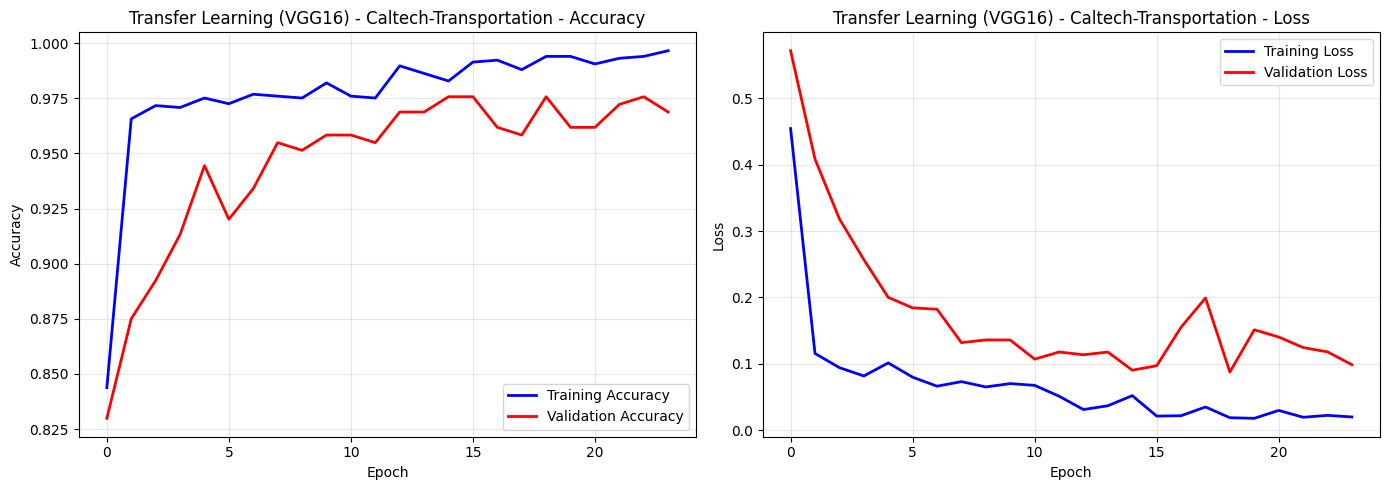

In [16]:
# Plot Transfer Learning training history
plot_training_history(transfer_history, f"Transfer Learning (VGG16) - {DATASET_NAME}")

### 6.3 Αξιολόγηση Transfer Learning στο Test Set

In [17]:
# Αξιολόγηση στο test set
test_generator.reset()
transfer_results = transfer_model.evaluate(test_generator, verbose=1)

print("\n" + "=" * 60)
print(f"TRANSFER LEARNING (VGG16) - TEST RESULTS ({DATASET_NAME})")
print("=" * 60)
print(f"Test Loss: {transfer_results[0]:.4f}")
print(f"Test Accuracy: {transfer_results[1]*100:.2f}%")
print("=" * 60)

# Αποθήκευση αποτελεσμάτων για σύγκριση
transfer_accuracy = transfer_results[1]

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.9956 - loss: 0.0184

TRANSFER LEARNING (VGG16) - TEST RESULTS (Caltech-Transportation)
Test Loss: 0.0285
Test Accuracy: 99.18%


## 7. Σύγκριση Μοντέλων (Deep Learning)

ΣΥΓΚΡΙΣΗ ΜΟΝΤΕΛΩΝ - Caltech-Transportation

Model                          Test Accuracy        Parameters          
----------------------------------------------------------------------
Custom CNN                      43.72%                   8,679,077
Transfer Learning (VGG16)       99.18%                  15,112,005
----------------------------------------------------------------------


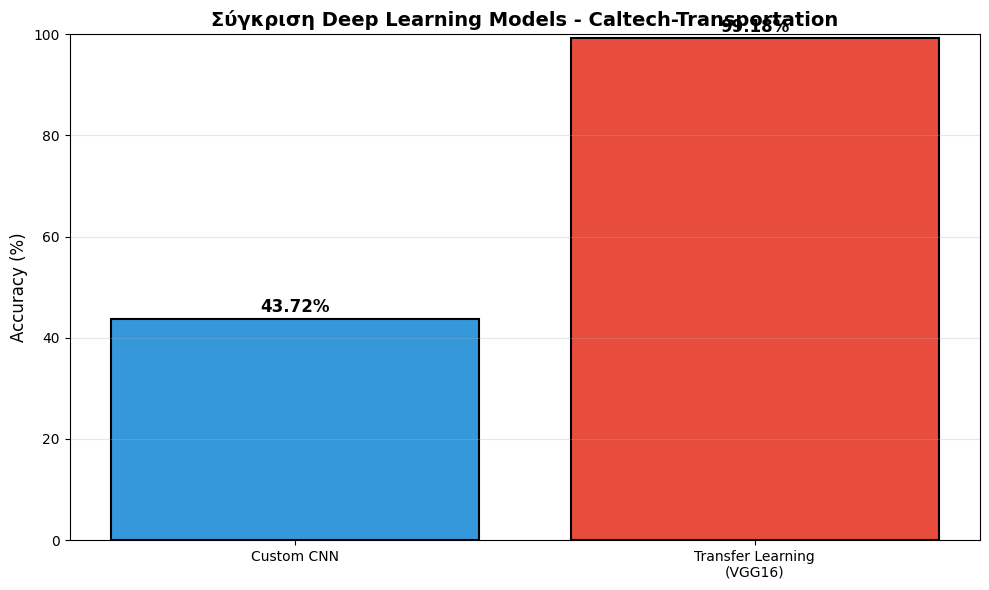

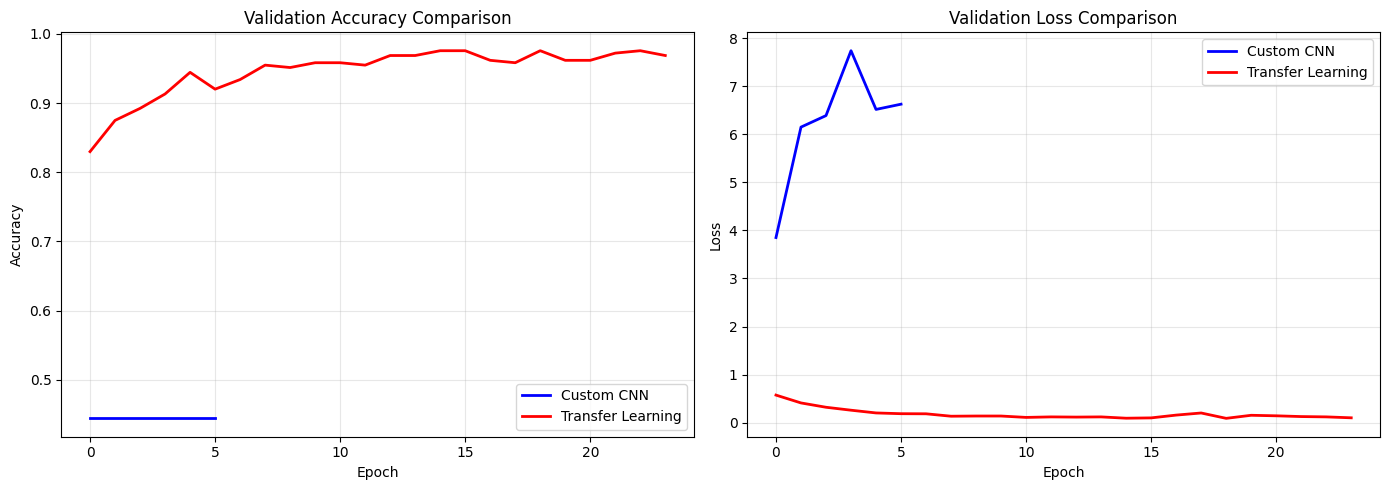

In [18]:
# Σύγκριση των δύο μοντέλων
print("=" * 70)
print(f"ΣΥΓΚΡΙΣΗ ΜΟΝΤΕΛΩΝ - {DATASET_NAME}")
print("=" * 70)
print(f"\n{'Model':<30} {'Test Accuracy':<20} {'Parameters':<20}")
print("-" * 70)
print(f"{'Custom CNN':<30} {custom_cnn_accuracy*100:>6.2f}%             {custom_cnn.count_params():>15,}")
print(f"{'Transfer Learning (VGG16)':<30} {transfer_accuracy*100:>6.2f}%             {transfer_model.count_params():>15,}")
print("-" * 70)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
models_names = ['Custom CNN', 'Transfer Learning\n(VGG16)']
accuracies = [custom_cnn_accuracy * 100, transfer_accuracy * 100]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(models_names, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add values on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title(f'Σύγκριση Deep Learning Models - {DATASET_NAME}', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Σύγκριση training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].plot(custom_history.history['val_accuracy'], 'b-', label='Custom CNN', linewidth=2)
axes[0].plot(transfer_history.history['val_accuracy'], 'r-', label='Transfer Learning', linewidth=2)
axes[0].set_title('Validation Accuracy Comparison', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss comparison
axes[1].plot(custom_history.history['val_loss'], 'b-', label='Custom CNN', linewidth=2)
axes[1].plot(transfer_history.history['val_loss'], 'r-', label='Transfer Learning', linewidth=2)
axes[1].set_title('Validation Loss Comparison', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Ανάλυση Ανά Κλάση - Confusion Matrix

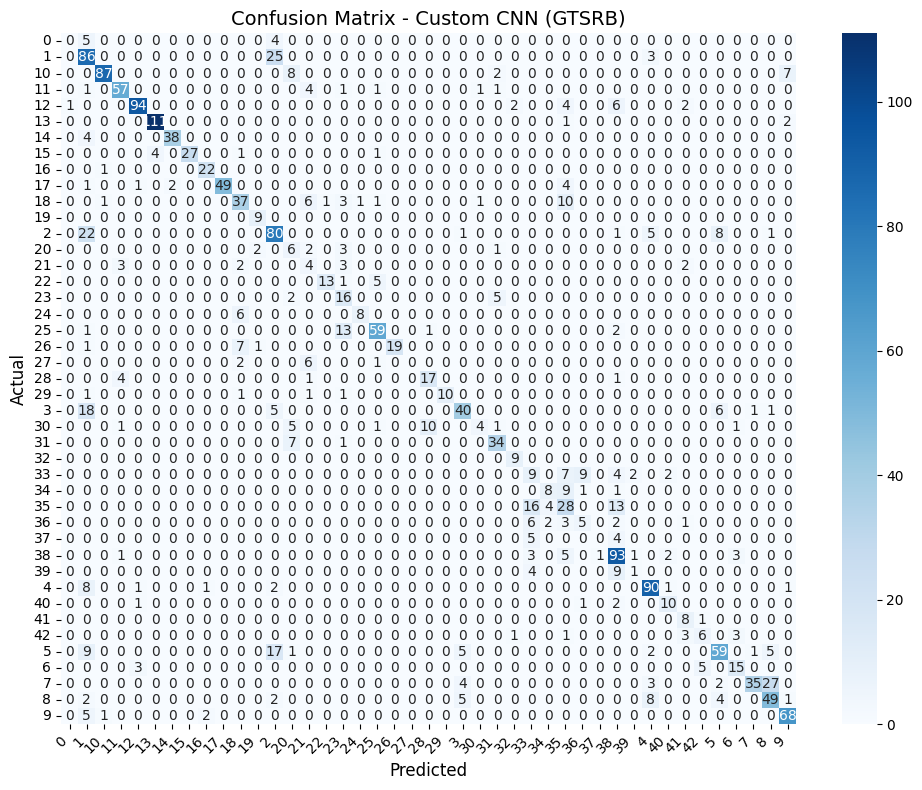


Classification Report - Custom CNN (GTSRB)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.52      0.75      0.62       114
          10       0.97      0.84      0.90       104
          11       0.86      0.86      0.86        66
          12       0.94      0.86      0.90       109
          13       0.97      0.97      0.97       114
          14       0.95      0.90      0.93        42
          15       1.00      0.82      0.90        33
          16       0.88      0.96      0.92        23
          17       1.00      0.86      0.92        57
          18       0.66      0.61      0.63        61
          19       0.75      1.00      0.86         9
           2       0.59      0.68      0.63       118
          20       0.21      0.43      0.28        14
          21       0.17      0.29      0.21        14
          22       0.93      0.68      0.79        19
          23       0.38      0.70    

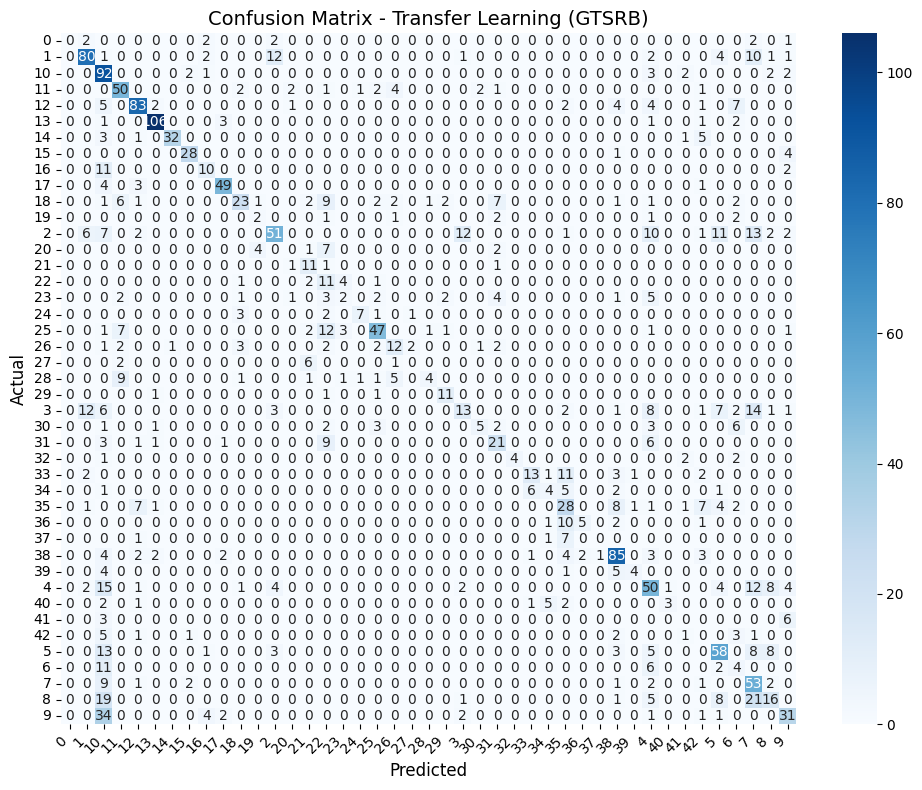


Classification Report - Transfer Learning (GTSRB)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.76      0.70      0.73       114
          10       0.36      0.88      0.51       104
          11       0.64      0.76      0.69        66
          12       0.79      0.76      0.78       109
          13       0.93      0.93      0.93       114
          14       0.97      0.76      0.85        42
          15       0.85      0.85      0.85        33
          16       0.50      0.43      0.47        23
          17       0.86      0.86      0.86        57
          18       0.66      0.38      0.48        61
          19       0.29      0.22      0.25         9
           2       0.68      0.43      0.53       118
          20       0.00      0.00      0.00        14
          21       0.44      0.79      0.56        14
          22       0.18      0.58      0.28        19
          23       0.20      0

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix_and_report(model, generator, title="Model"):
    """Εμφάνιση Confusion Matrix και Classification Report"""
    generator.reset()
    
    # Predictions
    predictions = model.predict(generator, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    
    # Class names
    class_names = list(generator.class_indices.keys())
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Confusion Matrix - {title}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print(f"\nClassification Report - {title}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Per-class accuracy
    print(f"\nPer-Class Accuracy - {title}")
    print("-" * 40)
    for i, class_name in enumerate(class_names):
        class_mask = y_true == i
        class_accuracy = np.mean(y_pred[class_mask] == i) * 100
        print(f"{class_name:20s}: {class_accuracy:6.2f}%")

# Confusion matrices για τα δύο μοντέλα
test_generator.reset()
plot_confusion_matrix_and_report(custom_cnn, test_generator, f"Custom CNN ({DATASET_NAME})")

test_generator.reset()
plot_confusion_matrix_and_report(transfer_model, test_generator, f"Transfer Learning ({DATASET_NAME})")

## 9. Τελική Σύνοψη - Β' Μέρος

In [19]:
# Τελική σύνοψη
print("=" * 70)
print("ΤΕΛΙΚΗ ΣΥΝΟΨΗ - Β' ΜΕΡΟΣ")
print("=" * 70)
print(f"\nDataset: {DATASET_NAME}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

print("\n" + "-" * 70)
print("CUSTOM CNN")
print("-" * 70)
print(f"Architecture: 3 Conv Blocks (32→64→128 filters) + 2 Dense Layers")
print(f"Total Parameters: {custom_cnn.count_params():,}")
print(f"Training Epochs: {len(custom_history.history['accuracy'])}")
print(f"Final Training Accuracy: {custom_history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {custom_history.history['val_accuracy'][-1]*100:.2f}%")
print(f"TEST ACCURACY: {custom_cnn_accuracy*100:.2f}%")

print("\n" + "-" * 70)
print("TRANSFER LEARNING (VGG16)")
print("-" * 70)
print(f"Base Model: VGG16 (pre-trained on ImageNet)")
print(f"Strategy: Feature Extraction (frozen base)")
print(f"Total Parameters: {transfer_model.count_params():,}")
print(f"Trainable Parameters: {sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights]):,}")
print(f"Training Epochs: {len(transfer_history.history['accuracy'])}")
print(f"Final Training Accuracy: {transfer_history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {transfer_history.history['val_accuracy'][-1]*100:.2f}%")
print(f"TEST ACCURACY: {transfer_accuracy*100:.2f}%")

print("\n" + "=" * 70)
print("BEST MODEL:", "Transfer Learning (VGG16)" if transfer_accuracy > custom_cnn_accuracy else "Custom CNN")
print(f"Best Accuracy: {max(custom_cnn_accuracy, transfer_accuracy)*100:.2f}%")
print("=" * 70)

ΤΕΛΙΚΗ ΣΥΝΟΨΗ - Β' ΜΕΡΟΣ

Dataset: Caltech-Transportation
Number of Classes: 5
Image Size: (128, 128)
Batch Size: 32

----------------------------------------------------------------------
CUSTOM CNN
----------------------------------------------------------------------
Architecture: 3 Conv Blocks (32→64→128 filters) + 2 Dense Layers
Total Parameters: 8,679,077
Training Epochs: 6
Final Training Accuracy: 91.85%
Final Validation Accuracy: 44.44%
TEST ACCURACY: 43.72%

----------------------------------------------------------------------
TRANSFER LEARNING (VGG16)
----------------------------------------------------------------------
Base Model: VGG16 (pre-trained on ImageNet)
Strategy: Feature Extraction (frozen base)
Total Parameters: 15,112,005
Trainable Parameters: 396,293
Training Epochs: 24
Final Training Accuracy: 99.66%
Final Validation Accuracy: 96.88%
TEST ACCURACY: 99.18%

BEST MODEL: Transfer Learning (VGG16)
Best Accuracy: 99.18%
